# **NORMAL/ABNORMAL ARRHYTHMIA PREDICTION NOTEBOOK**

## **Summary**

1. Importing libraries and data
2. Data cleaning and preparation
3. Data transformation function
4. Training: first models
5. Training: hyperparameters tuning
6. Model finalization
7. Test on unseen data

.

.
## **1. Importing libraries and data**

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from scipy.stats import skew
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, KFold
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn import svm

import warnings
warnings.simplefilter("ignore")

In [2]:
#Import data
Data = pd.read_csv("Data.csv")
Data

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature271,Feature272,Feature273,Feature274,Feature275,Feature276,Feature277,Feature278,Feature279,Class
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0,-0.1,3.9,25.4,62.8,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,53,1,160,70,80,199,382,154,117,-37,...,0.0,4.3,-5.0,0.0,0,0.7,0.6,-4.4,-0.5,1
448,37,0,190,85,100,137,361,201,73,86,...,0.0,15.6,-1.6,0.0,0,0.4,2.4,38.0,62.4,10
449,36,0,166,68,108,176,365,194,116,-85,...,0.0,16.3,-28.6,0.0,0,1.5,1.0,-44.2,-33.2,2
450,32,1,155,55,93,106,386,218,63,54,...,-0.4,12.0,-0.7,0.0,0,0.5,2.4,25.0,46.6,1


In [3]:
#Data information
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Columns: 280 entries, Feature1 to Class
dtypes: float64(121), int64(159)
memory usage: 988.9 KB


.

Before moving on, let's create a Traning and a test set: this later will be used at the end of the notebook as *unseen data*.

The Test set will contain 3% of the data (~15 samples).

In [4]:
#Creation of a Training set and a Test set
X_train, X_test, y_train, y_test = train_test_split(Data.drop(["Class"],axis=1),
                                                    Data["Class"],
                                                    test_size = 0.03, random_state = 0, shuffle=True)
X_train.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature270,Feature271,Feature272,Feature273,Feature274,Feature275,Feature276,Feature277,Feature278,Feature279
351,53,1,156,65,73,160,359,248,37,33,...,-0.4,0.0,8.1,0.0,0.0,0,0.1,-0.8,22.6,10.8
21,45,0,169,67,90,122,336,177,78,81,...,-0.4,-0.6,8.3,-1.8,0.0,0,0.8,1.1,11.7,19.6
118,24,1,162,75,88,150,353,156,96,-21,...,-0.2,0.0,5.3,-1.6,0.0,0,0.7,1.2,7.4,15.5
1,56,1,165,64,81,174,401,149,39,25,...,-0.5,0.0,8.5,0.0,0.0,0,0.2,2.1,20.4,38.8
10,62,0,170,72,102,135,401,156,83,72,...,-0.4,-0.5,9.0,-2.0,0.0,0,0.8,0.9,12.3,19.3


.

.

## **2. Data cleaning and preparation**

In [5]:
#Missing values
print("Number of missing values: ",X_train.isna().sum().sum(),"(",100*X_train.isna().sum().sum()/(X_train.shape[0]*X_train.shape[1]),"%)")

Number of missing values:  393 ( 0.32159866450630925 %)


.

A very small percentage compared to the whole dataset.

In [6]:
#Features with missing values
for i in X_train.columns:
    if X_train[i].isna().sum() > 0 :
        print(i)

Feature11
Feature12
Feature13
Feature14
Feature15


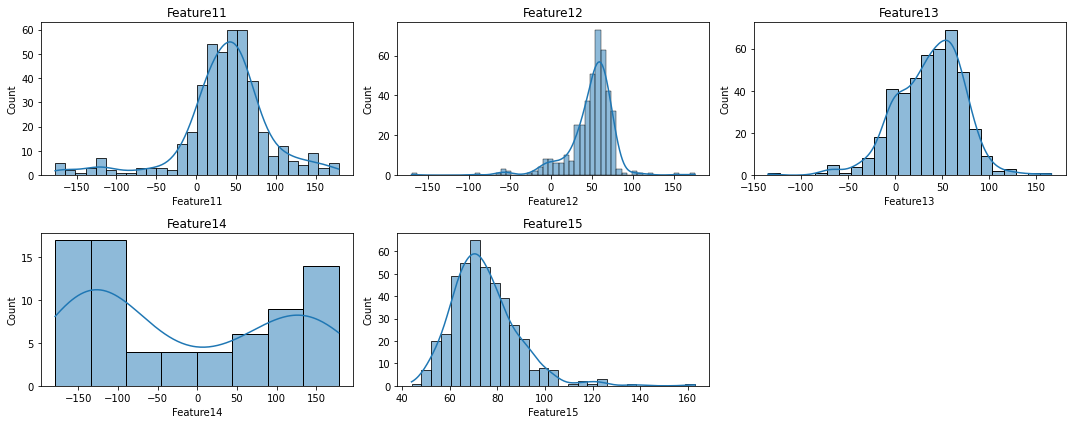

In [7]:
#Data distribution of features 11-12-13-14-15
plt.figure(figsize=(15,6))
k=1
for i in ["Feature11","Feature12","Feature13","Feature14","Feature15"] :
    plt.subplot(2,3,k)
    sn.histplot(x=X_train[i],kde=True)
    plt.title(i)
    k=k+1

plt.tight_layout()

.

For what concerns features 11-12-15, a simple mean/median-imputation may be sufficient.

Instead, for feature 14, that imputation method may not be a good choice given that the distribution is not Gaussian.

However, that feature (as others) represents an *angle*, and missing values can be replaced with 0 (which is the average angle between -180° and 180°)

or with the mean/median value of the distribution which is close to 0.

This procedure will be applied later.

.

Before moving on, let's find out more about each feature. 

Let's check if there are some features with only one unique value.

In [8]:
#Feature with one unique value
Number = 0
for i in X_train.columns :
    if len(X_train[i].unique())==1 :
        print(i, ": ", len(X_train[i].unique()))
        Number = Number + 1

if Number == 0 :
    print("All features have at least 2 unique valus")

Feature20 :  1
Feature68 :  1
Feature70 :  1
Feature84 :  1
Feature132 :  1
Feature133 :  1
Feature140 :  1
Feature142 :  1
Feature144 :  1
Feature146 :  1
Feature152 :  1
Feature157 :  1
Feature158 :  1
Feature165 :  1
Feature205 :  1
Feature265 :  1
Feature275 :  1


.

There is a way to transform those features and preserve the possible information they carry.

Let's take a look at some of them, in particular, those nominal values reported as "existence of ragger _ wave" in the desciption file (there are several similar groups).

In [9]:
#Example
X_train.iloc[:,21:27]

,Feature22,Feature23,Feature24,Feature25,Feature26,Feature27
351,0,0,0,0,0,0
21,0,0,0,0,0,0
118,0,0,0,0,0,0
1,0,0,0,0,0,0
10,0,0,0,0,0,0
...,...,...,...,...,...,...
323,0,0,0,0,0,0
192,0,0,0,0,0,0
117,0,0,0,0,0,0
47,0,0,0,0,0,0


.

All those groups of features contain 1s and 0s that can be combinedto form a binary number of 6 digits:
    
In this way, each combination preserve the initial information and represent one single case.

A column with only 0s, will be included in those binary numbers without dropping it.

In [10]:
#Example
Bin = []
i = 0
while i<len(X_train) :
    Sum = 0
    k=0
    j=26
    while j>=21 :
        Sum = Sum + X_train.iloc[i,j]*2**k
        k=k+1
        j=j-1
    Bin.append(Sum)
    i=i+1
    
np.unique(Bin)

array([ 0,  1,  2,  3,  4,  8, 16, 17, 32])

.

In this example, those six columns can be combined in one column having 9 different classes.

Notice that, from the binary number, it is always possible to go back to the original features (number --> binary number --> real values).

.

The groups of features to consider are:
-   22-27
-   34-39
-   46-51
-   58-63
-   70-75
-   82-87
-   94-99
-   106-111
-   118-123
-   130-135
-   142-147
-   154-159

In [11]:
#Binary transformation
for kk in [27,39,51,63,75,87,99,111,123,135,147,159] :
    Bin = []
    i = 0
    while i<len(X_train) :
        Sum = 0
        k=0
        j=kk-1
        while j>=kk-6 :
            Sum = Sum + X_train.iloc[i,j]*2**k
            k=k+1
            j=j-1
        Bin.append(Sum)
        i=i+1
    X_train.iloc[:,kk-1] = Bin

    
#Find and remove the unnecessary columns keeping only the first column of each group
Columns_del = []
for kk in [27,39,51,63,75,87,99,111,123,135,147,159] :
    j=kk-1
    while j>=kk-5 :
        Columns_del.append(j)
        j=j-1

X_train.drop(X_train.columns[Columns_del],axis=1,inplace=True)


#Print columns with one value
for i in X_train.columns :
    if len(X_train[i].unique())==1 :
        print(i, ": ", len(X_train[i].unique()))
        Number = Number + 1

Feature20 :  1
Feature68 :  1
Feature70 :  1
Feature140 :  1
Feature142 :  1
Feature152 :  1
Feature165 :  1
Feature205 :  1
Feature265 :  1
Feature275 :  1


.

The number of columns with one value has been reduced.

There are still some columns to take care of:
  - Features 20-68-140-152 are related to the S' wave presence (all equal to 0)
  - Features 165-205-265-275 are related to the S' wave amplitude (all equal to 0)
  - Features 70-142 are those already treated for which the loop above found only one combination

For the first features, one way is to combine columns related to R' waves and S' waves together (sum of values).

The columns to take care of are:
-   19-20
-   32-33
-   44-45
-   56-57
-   68-69
-   80-81
-   92-93
-   104-104
-   116-117
-   128-129
-   140-141
-   152-153

In [12]:
#Sum of R' wave features and S' wave features (presence)
#The first column of each group will be kept (it will contain the sum of values) while the second column will be dropped from the dataset
for kk in [19,32,44,56,68,80,92,104,116,128,140,152] :
    exec(f"X_train['Feature{kk}'] = X_train['Feature{kk}'] + X_train['Feature{kk+1}']; X_train.drop(['Feature{kk+1}'],axis=1, inplace=True)")
    
    
#Print columns with one value
for i in X_train.columns :
    if len(X_train[i].unique())==1 :
        print(i, ": ", len(X_train[i].unique()))
        Number = Number + 1

Feature70 :  1
Feature142 :  1
Feature165 :  1
Feature205 :  1
Feature265 :  1
Feature275 :  1


.

The same procedure (i.e. sum of values) can be applied to some other features:
-  164-165
-  204-205
-  264-265
-  274-275

In [13]:
#Sum of R' wave features and S' wave features (amplitude)
#The first column of each group will be kept (it will contain the sum of values) while the second column will be dropped from the dataset
for kk in [164,204,264,274] :
    exec(f"X_train['Feature{kk}'] = X_train['Feature{kk}'] + X_train['Feature{kk+1}']; X_train.drop(['Feature{kk+1}'],axis=1, inplace=True)")
    

    #Print columns with one value
for i in X_train.columns :
    if len(X_train[i].unique())==1 :
        print(i, ": ", len(X_train[i].unique()))
        Number = Number + 1

Feature70 :  1
Feature142 :  1


.

The remaining columns are those features for which the loop above found only one binary combination.

The simplest solution is to drop them from the dataset.

In [14]:
#Drop features with one unique value
X_train.drop(["Feature70","Feature142"],axis=1, inplace=True)
X_train.shape

(438, 201)

.

The dataset comprices only 201 columns.

.

Now, it is time to deal with missing values by replacing them with the median of each feature.

In [15]:
#Missing value - median imputation
for i in X_train.columns :
    exec(f"Median_{i} = X_train[i].median() ; X_train[i].fillna(Median_{i},inplace=True)")    
    
#Print number of missing values
print("Number of missing values: {}".format(X_train.isna().sum().sum()))

Number of missing values: 0


.

The dataset is finally complete.

.

Now, it is possible to scale all features using the MinMaxScaler.

In [16]:
#Scaling features
Numeric_scaler = MinMaxScaler()               #It will be used later
Numeric_scaler.fit(X_train)
A = Numeric_scaler.transform(X_train)
X_train = pd.DataFrame(A, columns=X_train.columns)

.

Let's take a look at the target variable.

In [17]:
#Value counts of the target variable
y_train.value_counts()

1     239
10     47
2      43
6      25
16     21
4      15
3      13
5      13
9       8
15      5
14      4
7       3
8       2
Name: Class, dtype: int64

.

It is highly umbalanced between the normal class (1) and the abnormal (the others).

What can be done is to treat 1 as positive class, and all the others like negative class making the dataset balanced (1: 239, 0: 199)

In [18]:
#Transformation of the target variable
y_train.iloc[np.where(y_train!=1)[0]] = 0
y_train = np.array(y_train)

.

What features can be neglected?

Given the large number of features, a PCA will be applied to reduce their number, preserving 95% of the total information.

In [19]:
#Feature selection - PCA decomposition
B = PCA(n_components = 0.95)             #95%
B2 = B.fit(X_train)                      #It will be used later
X_train_pca = B2.transform(X_train)
X_train_pca.shape

(438, 66)

.

Now, the final dataset has only 66 features (against the initial number of 280).

.

.

## **3. Data transformation function**

Before moving one, let's create a function containing all the procedures and transformation shown above

The function will be used to transform the *unseen data* at the end of the notebook.

In [20]:
def Data_transformation(X,y) :                       
    #(1) Combine and drop - part 1
    for kk in [27,39,51,63,75,87,99,111,123,135,147,159] :
        Bin = []
        i = 0
        while i<len(X) :
            Sum = 0
            k=0
            j=kk-1
            while j>=kk-6 :
                Sum = Sum + X.iloc[i,j]*2**k
                k=k+1
                j=j-1
            Bin.append(Sum)
            i=i+1
        X.iloc[:,kk-1] = Bin

    Columns_del = []
    for kk in [27,39,51,63,75,87,99,111,123,135,147,159] :
        j=kk-1
        while j>=kk-5 :
            Columns_del.append(j)
            j=j-1

    X.drop(X.columns[Columns_del],axis=1,inplace=True)

    #(2) Combine and drop - part 2
    for kk in [19,32,44,56,68,80,92,104,116,128,140,152] :
        exec(f"X['Feature{kk}'] = X['Feature{kk}'] + X['Feature{kk+1}']; X.drop(['Feature{kk+1}'],axis=1, inplace=True)")
    
    #(3) Combine and drop - part 3
    for kk in [164,204,264,274] :
        exec(f"X['Feature{kk}'] = X['Feature{kk}'] + X['Feature{kk+1}']; X.drop(['Feature{kk+1}'],axis=1, inplace=True)")
    
    #(4) Drop negligible features
    X.drop(["Feature70","Feature142"],axis=1, inplace=True)
    
    #(5) Replace missing values with median values
    for i in X.columns :
        exec(f"X[i].fillna(Median_{i},inplace=True)")  

    #(6) Scaling features
    A = Numeric_scaler.transform(X)
    X = pd.DataFrame(A, columns = X.columns)        
        
    #(7) Class transformation within the target variable
    y.iloc[np.where(y!=1)[0]] = 0
    y = np.array(y)
    
    #(8) PCA dimensionality reduction
    X = B2.transform(X)


    return X,y

.

.

## **4. Training: first models**

First of all, let's create a Training set (to train models) and a Test set (to evaluate their performace).

In [21]:
#Creation of Training set and Test set (split: 80-20%)
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_train_pca,y_train,test_size = 0.2, random_state = 0, shuffle=True)

.

Several models will be applied on the Training set to predict the variable "Class".

A stratified k-fold cross-valiation method will be used to evaluate each model mean score.

In [22]:
#K-fold splitting
CV = StratifiedKFold(n_splits = 5, random_state = 0, shuffle = True)

#Iterative training
Iterations = 20
Model_log2_acc,Model_tree2_acc,Model_ran2_acc,Model_xgb2_acc,Model_svm2_acc,Model_knn2_acc = 0,0,0,0,0,0
Model_log2_pre,Model_tree2_pre,Model_ran2_pre,Model_xgb2_pre,Model_svm2_pre,Model_knn2_pre = 0,0,0,0,0,0
Model_log2_rec,Model_tree2_rec,Model_ran2_rec,Model_xgb2_rec,Model_svm2_rec,Model_knn2_rec = 0,0,0,0,0,0
Model_log2_f1,Model_tree2_f1,Model_ran2_f1,Model_xgb2_f1,Model_svm2_f1,Model_knn2_f1 = 0,0,0,0,0,0
Model_log2_auc,Model_tree2_auc,Model_ran2_auc,Model_xgb2_auc,Model_svm2_auc,Model_knn2_auc = 0,0,0,0,0,0
for i in range(Iterations) :
    print(f'\r{100*(i)/(Iterations)} %', end='')       #Counter (%)
    #Logistic regression
    Model_log = LogisticRegression()
    Model_log2_acc = Model_log2_acc + cross_val_score(Model_log, X_train_t, y_train_t, cv = CV, scoring = "accuracy").mean()
    Model_log2_pre = Model_log2_pre + cross_val_score(Model_log, X_train_t, y_train_t, cv = CV, scoring = "precision").mean()
    Model_log2_rec = Model_log2_rec + cross_val_score(Model_log, X_train_t, y_train_t, cv = CV, scoring = "recall").mean()
    Model_log2_f1 = Model_log2_f1 + cross_val_score(Model_log, X_train_t, y_train_t, cv = CV, scoring = "f1").mean()
    Model_log2_auc = Model_log2_auc + cross_val_score(Model_log, X_train_t, y_train_t, cv = CV, scoring = "roc_auc").mean()

    #Decision tree
    Model_tree = DecisionTreeClassifier(random_state=0)
    Model_tree2_acc = Model_tree2_acc + cross_val_score(Model_tree, X_train_t, y_train_t, cv = CV, scoring = "accuracy").mean()
    Model_tree2_pre = Model_tree2_pre + cross_val_score(Model_tree, X_train_t, y_train_t, cv = CV, scoring = "precision").mean()
    Model_tree2_rec = Model_tree2_rec + cross_val_score(Model_tree, X_train_t, y_train_t, cv = CV, scoring = "recall").mean()   
    Model_tree2_f1 = Model_tree2_f1 + cross_val_score(Model_tree, X_train_t, y_train_t, cv = CV, scoring = "f1").mean()
    Model_tree2_auc = Model_tree2_auc + cross_val_score(Model_tree, X_train_t, y_train_t, cv = CV, scoring = "roc_auc").mean()
    
    #Random forest
    Model_ran = RandomForestClassifier(random_state=0)
    Model_ran2_acc = Model_ran2_acc + cross_val_score(Model_ran, X_train_t, y_train_t, cv = CV, scoring = "accuracy").mean()
    Model_ran2_pre = Model_ran2_pre + cross_val_score(Model_ran, X_train_t, y_train_t, cv = CV, scoring = "precision").mean()
    Model_ran2_rec = Model_ran2_rec + cross_val_score(Model_ran, X_train_t, y_train_t, cv = CV, scoring = "recall").mean()  
    Model_ran2_f1 = Model_ran2_f1 + cross_val_score(Model_ran, X_train_t, y_train_t, cv = CV, scoring = "f1").mean()
    Model_ran2_auc = Model_ran2_auc + cross_val_score(Model_ran, X_train_t, y_train_t, cv = CV, scoring = "roc_auc").mean()
    
    #XGBoost
    Model_xgb = xgb.XGBClassifier(eval_metric="logloss", use_label_encoder=False, seed=0)
    Model_xgb2_acc = Model_xgb2_acc + cross_val_score(Model_xgb, X_train_t, y_train_t, cv = CV, scoring = "accuracy").mean()
    Model_xgb2_pre = Model_xgb2_pre + cross_val_score(Model_xgb, X_train_t, y_train_t, cv = CV, scoring = "precision").mean()
    Model_xgb2_rec = Model_xgb2_rec + cross_val_score(Model_xgb, X_train_t, y_train_t, cv = CV, scoring = "recall").mean()   
    Model_xgb2_f1 = Model_xgb2_f1 + cross_val_score(Model_xgb, X_train_t, y_train_t, cv = CV, scoring = "f1").mean()
    Model_xgb2_auc = Model_xgb2_auc + cross_val_score(Model_xgb, X_train_t, y_train_t, cv = CV, scoring = "roc_auc").mean()
    
    #SVM
    Model_svm = svm.SVC()
    Model_svm2_acc = Model_svm2_acc + cross_val_score(Model_svm, X_train_t, y_train_t, cv = CV, scoring = "accuracy").mean()
    Model_svm2_pre = Model_svm2_pre + cross_val_score(Model_svm, X_train_t, y_train_t, cv = CV, scoring = "precision").mean()
    Model_svm2_rec = Model_svm2_rec + cross_val_score(Model_svm, X_train_t, y_train_t, cv = CV, scoring = "recall").mean()   
    Model_svm2_f1 = Model_svm2_f1 + cross_val_score(Model_svm, X_train_t, y_train_t, cv = CV, scoring = "f1").mean()
    Model_svm2_auc = Model_svm2_auc + cross_val_score(Model_svm, X_train_t, y_train_t, cv = CV, scoring = "roc_auc").mean()
    
    #KNN
    Model_knn = KNeighborsClassifier()
    Model_knn2_acc = Model_knn2_acc + cross_val_score(Model_knn, X_train_t, y_train_t, cv = CV, scoring = "accuracy").mean()
    Model_knn2_pre = Model_knn2_pre + cross_val_score(Model_knn, X_train_t, y_train_t, cv = CV, scoring = "precision").mean()
    Model_knn2_rec = Model_knn2_rec + cross_val_score(Model_knn, X_train_t, y_train_t, cv = CV, scoring = "recall").mean()   
    Model_knn2_f1 = Model_knn2_f1 + cross_val_score(Model_knn, X_train_t, y_train_t, cv = CV, scoring = "f1").mean()
    Model_knn2_auc = Model_knn2_auc + cross_val_score(Model_knn, X_train_t, y_train_t, cv = CV, scoring = "roc_auc").mean()
    
    
#Final results
Data_res = {"Mean_accuracy" : [Model_log2_acc/Iterations,Model_tree2_acc/Iterations,Model_ran2_acc/Iterations,Model_xgb2_acc/Iterations,
                               Model_svm2_acc/Iterations,Model_knn2_acc/Iterations],
        "Mean_Precision" : [Model_log2_pre/Iterations,Model_tree2_pre/Iterations,Model_ran2_pre/Iterations,Model_xgb2_pre/Iterations,
                               Model_svm2_pre/Iterations,Model_knn2_pre/Iterations],
        "Mean_Recall" : [Model_log2_rec/Iterations,Model_tree2_rec/Iterations,Model_ran2_rec/Iterations,Model_xgb2_rec/Iterations,
                               Model_svm2_rec/Iterations,Model_knn2_rec/Iterations],
        "Mean_F1_score" : [Model_log2_f1/Iterations,Model_tree2_f1/Iterations,Model_ran2_f1/Iterations,Model_xgb2_f1/Iterations,
                               Model_svm2_f1/Iterations,Model_knn2_f1/Iterations],
        "Mean_AUC_score" : [Model_log2_auc/Iterations,Model_tree2_auc/Iterations,Model_ran2_auc/Iterations,Model_xgb2_auc/Iterations,
                               Model_svm2_auc/Iterations,Model_knn2_auc/Iterations]
       }

Results = pd.DataFrame(data = Data_res,index = ["Logistic", "DecisionTree","RandomForest","XGBoost","SVM","KNN"])
Results.sort_values(by="Mean_accuracy",ascending=False)

95.0 %

,Mean_accuracy,Mean_Precision,Mean_Recall,Mean_F1_score,Mean_AUC_score
SVM,0.797143,0.768421,0.900000,0.827635,0.851809
Logistic,0.782857,0.766810,0.863158,0.811580,0.844901
XGBoost,0.765714,0.769246,0.821053,0.789166,0.834211
RandomForest,0.754286,0.760583,0.800000,0.778370,0.822204
DecisionTree,0.662857,0.670508,0.752632,0.707567,0.654441
KNN,0.654286,0.625623,0.905263,0.739665,0.729688


.

.

## **5. Training: hyperparameters tuning**

The best models are SVM and Logistc.

Let's proceed with their hyperparameter tuning. The scoring metric will be the *accuracy*.

In [23]:
#Hyperameters grid
Params_svm = {"C":[0.001,0.01,0.1,0.5,1,5,10], "kernel":["linear", "poly","rbf","sigmoid"]}
Params_log = {"penalty":["l1","l2","elasticnet","none"], "C":[0.001,0.01,0.1,0.5,1,5,10], "solver":["newton-cg","lbfgs","liblinear","saga"], "max_iter":[1e04]}

#Grid search with a 5-fold cross-validation method\
CV = KFold(n_splits=5, random_state = 0, shuffle=True)
Grid_svm = GridSearchCV(Model_svm, cv = CV, param_grid = Params_svm, scoring = "accuracy", n_jobs = -1, return_train_score=True)
Grid_svm2 = Grid_svm.fit(X_train_t, y_train_t)
print("SVM model: done!")
Grid_log = GridSearchCV(Model_log, cv = CV, param_grid = Params_log, scoring = "accuracy", n_jobs = -1, return_train_score=True)
Grid_log2 = Grid_log.fit(X_train_t, y_train_t)
print("Logistic model: done!")

print("\n\nThe best SVM model is: ",Grid_svm2.best_params_)
print("The best Logistic model is: ",Grid_log2.best_params_)
print("\nThe best SVM Accuracy is: ",Grid_svm2.best_score_)
print("The best Logistic Accuracy is: ",Grid_log2.best_score_)

SVM model: done!


/home/samuele/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/home/samuele/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/home/samuele/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/home/samuele/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/home/samuele/miniconda3/lib/python3.7/s

Logistic model: done!


The best SVM model is:  {'C': 1, 'kernel': 'linear'}
The best Logistic model is:  {'C': 10, 'max_iter': 10000.0, 'penalty': 'l2', 'solver': 'newton-cg'}

The best SVM Accuracy is:  0.8
The best Logistic Accuracy is:  0.7657142857142857


.

The SVM model seems to be the best one.

Let's take a look at the training accuracy vs. validation accuracy plot to understand if the models are overfitting the data.

A shaded blue region will be added on the plot: it represent a sort "confidence interval against overfitting"

Points in the region are related to model not overfitting (or slighlty overfitting the data).

Points outside the region are related to models that overfitted the data.

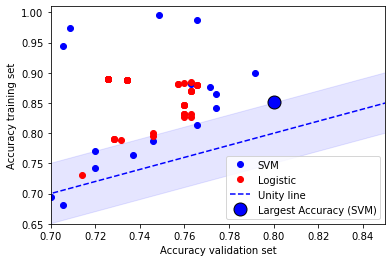

In [24]:
#Training vs. Validation accuracy
A = pd.concat([pd.Series(Grid_svm2.cv_results_["mean_test_score"]),pd.Series(Grid_svm2.cv_results_["mean_train_score"])],axis=1)
B = pd.concat([pd.Series(Grid_log2.cv_results_["mean_test_score"]),pd.Series(Grid_log2.cv_results_["mean_train_score"])],axis=1)
A.columns=["Test","Train"]
B.columns=["Test","Train"]
A.sort_values("Test")
B.sort_values("Test")
plt.plot(A.Test,A.Train,'ob')
plt.plot(B.Test,B.Train,'or')
plt.plot([0.4,0.90],[0.4,0.90],'--b')
plt.fill_between([0.4,0.90],[0.35,0.85],[0.45,0.95],color='blue',alpha=0.1, label="_nolegend_")
plt.plot(A.Test[np.argmax(A.Test)],A.Train[np.argmax(A.Test)],'bo',markersize=13,mec="black")
plt.ylim([0.65,1.01])
plt.xlim([0.7,0.85])
plt.xlabel("Accuracy validation set")
plt.ylabel("Accuracy training set")
plt.legend(["SVM","Logistic","Unity line","Largest Accuracy (SVM)"], loc="lower right")

.

The SVM model with the largest accuracy is slighlty overfitting the data (at the border of the shaded blue region).

Tet's try to explore further its hyperparameters.

In [25]:
#Hyperameters grid
Params_svm = {"C":np.arange(0.0,10,0.1), "kernel":["linear","rbf"]}

#Grid search with a 5-fold cross-validation method\
CV = KFold(n_splits=5, random_state = 0, shuffle=True)
Grid_svm22 = GridSearchCV(Model_svm, cv = CV, param_grid = Params_svm, scoring = "accuracy", n_jobs = -1, return_train_score=True)
Grid_svm222 = Grid_svm22.fit(X_train_t, y_train_t)

print("\n\nThe best SVM model is: ",Grid_svm222.best_params_)
print("\nThe best SVM Accuracy is: ",Grid_svm222.best_score_)



The best SVM model is:  {'C': 1.9000000000000001, 'kernel': 'linear'}

The best SVM Accuracy is:  0.8028571428571428


.

The new accuracy is slightly better than before

Let's take a look at the training vs. validation accuracy plot.

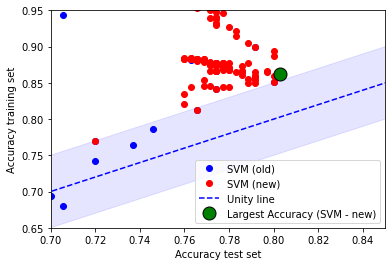

In [26]:
#Training vs. Validation accuracy
A = pd.concat([pd.Series(Grid_svm2.cv_results_["mean_test_score"]),pd.Series(Grid_svm2.cv_results_["mean_train_score"])],axis=1)
B = pd.concat([pd.Series(Grid_svm222.cv_results_["mean_test_score"]),pd.Series(Grid_svm222.cv_results_["mean_train_score"])],axis=1)
A.columns=["Test","Train"]
B.columns=["Test","Train"]
A.sort_values("Test")
B.sort_values("Test")
plt.plot(A.Test,A.Train,'ob')
plt.plot(B.Test,B.Train,'or')
plt.plot([0.4,0.90],[0.4,0.90],'--b')
plt.fill_between([0.4,0.90],[0.35,0.85],[0.45,0.95],color='blue',alpha=0.1, label="_nolegend_")
plt.plot(B.Test[np.argmax(B.Test)],B.Train[np.argmax(B.Test)],'go',markersize=13,mec="black")
plt.ylim([0.65,0.95])
plt.xlim([0.7,0.85])
plt.xlabel("Accuracy test set")
plt.ylabel("Accuracy training set")
plt.legend(["SVM (old)","SVM (new)","Unity line","Largest Accuracy (SVM - new)"], loc="lower right")

.

It is little bit worse than before (in terms of overfitting - slightly outside the shaded region)

For this reason, let's use the previous model (still a bit overfitting the data)

In [27]:
#Accuracy on training and test set
Model1 = svm.SVC(C = 1.0, kernel = "linear")
Model11 = Model1.fit(X_train_t,y_train_t)

Final_accuracy_tr = (Model11.predict(X_train_t) == y_train_t).sum()/len(y_train_t)
Final_accuracy_te = (Model11.predict(X_test_t) == y_test_t).sum()/len(y_test_t)
print("The Accuracy on the Training set is:  {:.2f}% (AUC: {:.2f})".format(100*Final_accuracy_tr,roc_auc_score(y_train_t,Model11.predict(X_train_t))))
print("The Accuracy on the Test set is:  {:.2f}% (AUC: {:.2f})\n".format(100*Final_accuracy_te,roc_auc_score(y_train_t,Model11.predict(X_train_t))))

The Accuracy on the Training set is:  84.57% (AUC: 0.84)
The Accuracy on the Test set is:  70.45% (AUC: 0.84)



.

The accuracy on the Test set is small and very different from the training set accuracy.

This can be due to the small number of samples (88) or to the slighlty overfitting model.

In [28]:
#Precision, Recall, F1-score, Confusion matrix
Conf_matrix = confusion_matrix(y_test_t, Model1.predict(X_test_t))
print("Precision: {:.2f}".format(precision_score(y_test_t, Model1.predict(X_test_t))))
print("Recall: {:.2f}".format(recall_score(y_test_t, Model1.predict(X_test_t))))
print("F1-score: {:.2f}\n".format(f1_score(y_test_t, Model1.predict(X_test_t))))
pd.DataFrame(data=Conf_matrix, columns=["Predicted_Abnormal","Predicted_Normal"], index=["Actual_Abnormal","Actual_Normal"])

Precision: 0.71
Recall: 0.80
F1-score: 0.75



,Predicted_Abnormal,Predicted_Normal
Actual_Abnormal,23,16
Actual_Normal,10,39


.

.

## **6. Model finalization**

Now, it is possible to *finalize* the model by using the whole dataset.

In [29]:
#Final training on the whole dataset
Model1 = svm.SVC(C=1.0, kernel="linear")
Best_model = Model1.fit(X_train_pca, y_train)

#Final accuracy on the whole dataset
Final_accuracy = (Best_model.predict(X_train_pca) == y_train).sum()/len(y_train)
print("The final Accuracy on the whole Training set is:  {:.2f}% (AUC: {:.2f})\n".format(100*Final_accuracy,roc_auc_score(y_train,Model11.predict(X_train_pca))))

#Precision, Recall, F1-score, Confusion matrix
Conf_matrix = confusion_matrix(y_train, Best_model.predict(X_train_pca))
print("\nPrecision: {:.2f}".format(precision_score(y_train, Best_model.predict(X_train_pca))))
print("Recall: {:.2f}".format(recall_score(y_train, Best_model.predict(X_train_pca))))
print("F1-score: {:.2f}\n".format(f1_score(y_train, Best_model.predict(X_train_pca))))
pd.DataFrame(data=Conf_matrix, columns=["Predicted_Abnormal","Predicted_Normal"], index=["Actual_Abnormal","Actual_Normal"])

The final Accuracy on the whole Training set is:  82.19% (AUC: 0.81)


Precision: 0.78
Recall: 0.93
F1-score: 0.85



,Predicted_Abnormal,Predicted_Normal
Actual_Abnormal,138,61
Actual_Normal,17,222


.

.

## **7. Test on unseen data**

Now, it is possible to use the model on the *unseen data*, randomly chosen at the beginning of this notebook.

First, data must be transformed before the model application.

In [30]:
#Data transformation
X_test, y_test = Data_transformation(X_test,y_test)

In [31]:
#Accuracy on the Test set
Final_accuracy_test = (Best_model.predict(X_test) == y_test).sum()/len(y_test)
print("The accuracy on the unseen Test set is:  {:.2f}%\n".format(100*Final_accuracy_test))

#Confusion matrix
Conf_matrix = confusion_matrix(y_test, Best_model.predict(X_test))
pd.DataFrame(data=Conf_matrix, columns=["Predicted_Abnormal","Predicted_Normal"], index=["Actual_Abnormal","Actual_Normal"])

The accuracy on the unseen Test set is:  85.71%



,Predicted_Abnormal,Predicted_Normal
Actual_Abnormal,6,2
Actual_Normal,0,6
